# Object Detection in Videos

In this tutorial, we'll demonstrate how to use Pixeltable to do frame-by-frame object detection, made simple through Pixeltable's video-related functionality:
* automatic frame extraction
* running complex functions against frames (in this case, the object detection model ResNet-50)
* reassembling frames back into videos

We'll be working with a single video file from Pixeltable's test data directory. Let's download that now:

In [1]:
import urllib.request

download_url = 'https://raw.github.com/pixeltable/pixeltable/master/docs/source/data/bangkok.mp4'
filename, _ = urllib.request.urlretrieve(download_url)

## Creating a tutorial directory and table

In Pixeltable, all data resides in tables, which themselves can be organized into a directory structure.

Let's start by creating a client and a `video_tutorial` directory:

In [1]:
import pixeltable as pxt

cl = pxt.Client()
cl.create_dir('video_tutorial', ignore_errors=True)

Connected to Pixeltable database at: postgresql://postgres:@/pixeltable?host=/Users/asiegel/.pixeltable/pgdata


We create a table for our videos, with a single column:

In [9]:
# Drop the tables if they exist, in case they were created by a previous
# run of the tutorial
cl.drop_table('video_tutorial.frames', ignore_errors=True)
cl.drop_table('video_tutorial.videos', ignore_errors=True)
# Create the `video_tutorial.videos` table
videos_table = cl.create_table('video_tutorial.videos', {'video': pxt.VideoType()})

Created table `videos`.


In order to interact with the frames, we take advantage of Pixeltable's component view concept: we create a "view" of our video table that contains one row for each frame of each video in the table. Pixeltable provides the built-in `FrameIterator` class for this.

In [10]:
from pixeltable.iterators import FrameIterator

frames_view = cl.create_view(
    'video_tutorial.frames',
    videos_table,
    iterator_class=FrameIterator,
    # `fps` determines the frame rate; a value of `0` indicates the native frame rate of the video.
    iterator_args={'video': videos_table.video, 'fps': 0}
)

Created view `frames` with 0 rows, 0 exceptions.


You'll see that neither the `videos` table nor the `frames` view has any actual data yet, because we haven't yet added any videos to the table. However, the `frames` view is now configured to automatically track the `videos` table as new data shows up.

The new view is automatically configured with six columns:
- `pos` - a system column that is part of every component view
- `video` - the column inherited from our base table (all base table columns are visible in any of its views)
- `frame_idx`, `pos_msec`, `pos_frame`, `frame` - these four columns are created by the `FrameIterator` class.

Let's have a look at the new view:

In [11]:
frames_view

Column Name,Type,Computed With
pos,int,
frame_idx,int,
pos_msec,float,
pos_frame,float,
frame,image,
video,video,


We'll now insert a single row into the videos table, containing a video of a busy intersection in Bangkok.

In [12]:
videos_table.insert(video='https://raw.github.com/pixeltable/pixeltable/master/docs/source/data/bangkok.mp4')

Inserting rows into `videos`: 1 rows [00:00, 167.39 rows/s]
Inserting rows into `frames`: 462 rows [00:00, 12673.52 rows/s]
Inserted 463 rows with 0 errors.


UpdateStatus(num_rows=463, num_computed_values=0, num_excs=0, updated_cols=[], cols_with_excs=[])

Notice that both the `videos` table and the `frames` view were automatically updated, expanding the single video into 462 rows in the view. Let's have a look.

In [13]:
videos_table.show()

video
""


127.0.0.1 - - [17/Apr/2024 17:13:44] "GET //Users/asiegel/.pixeltable/file_cache/70e68f453dc94a59a34d1dd7269a878f_0_64d1b7758cbd16719cba7134d89a68a7bf419ac4f086af7a411b8afaac3f39a2.mp4 HTTP/1.1" 200 -


You can double-click on the video to enlarge it.

Now let's peek at the first five rows of the frames view:

pos,frame,width,height
0,,1280,720
1,,1280,720
2,,1280,720
3,,1280,720
4,,1280,720

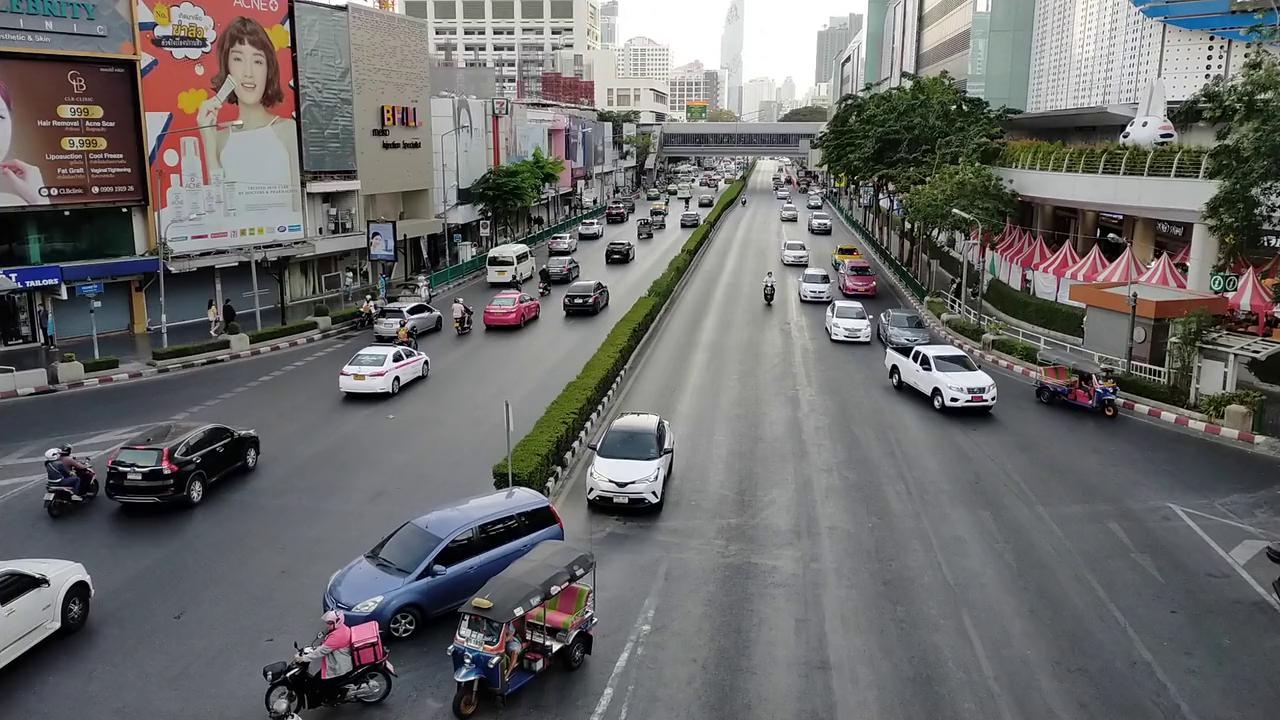
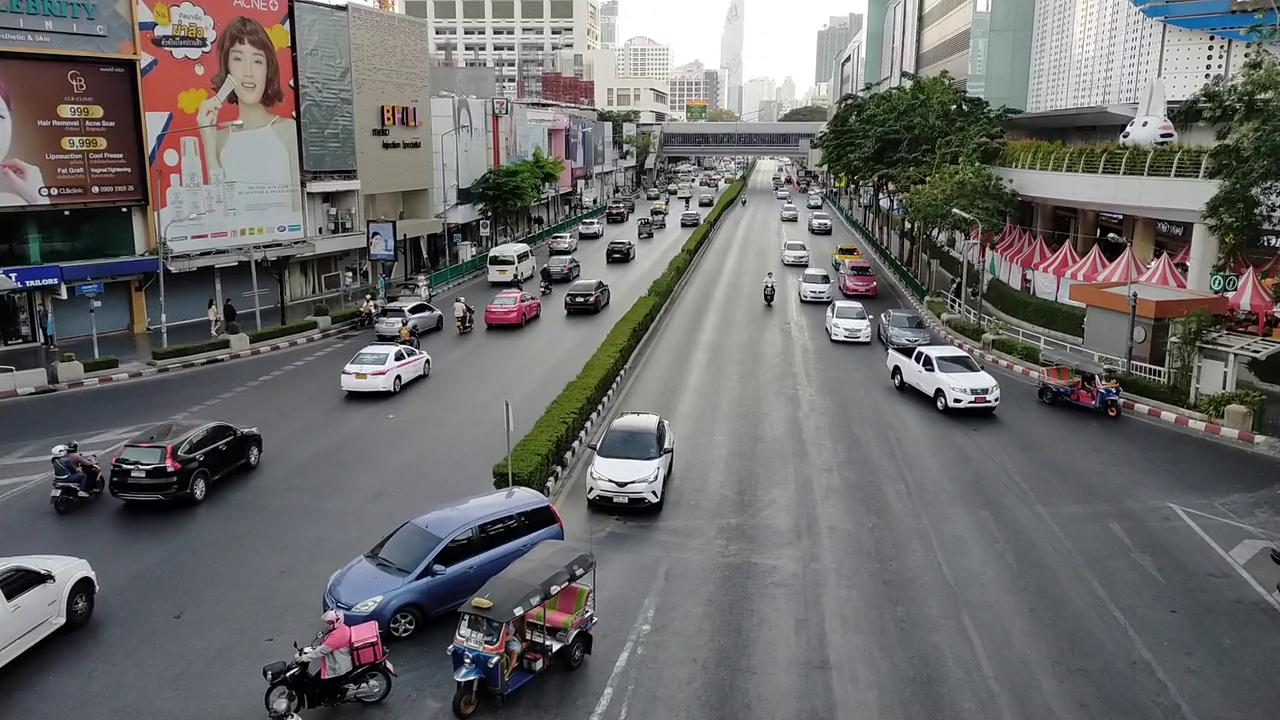
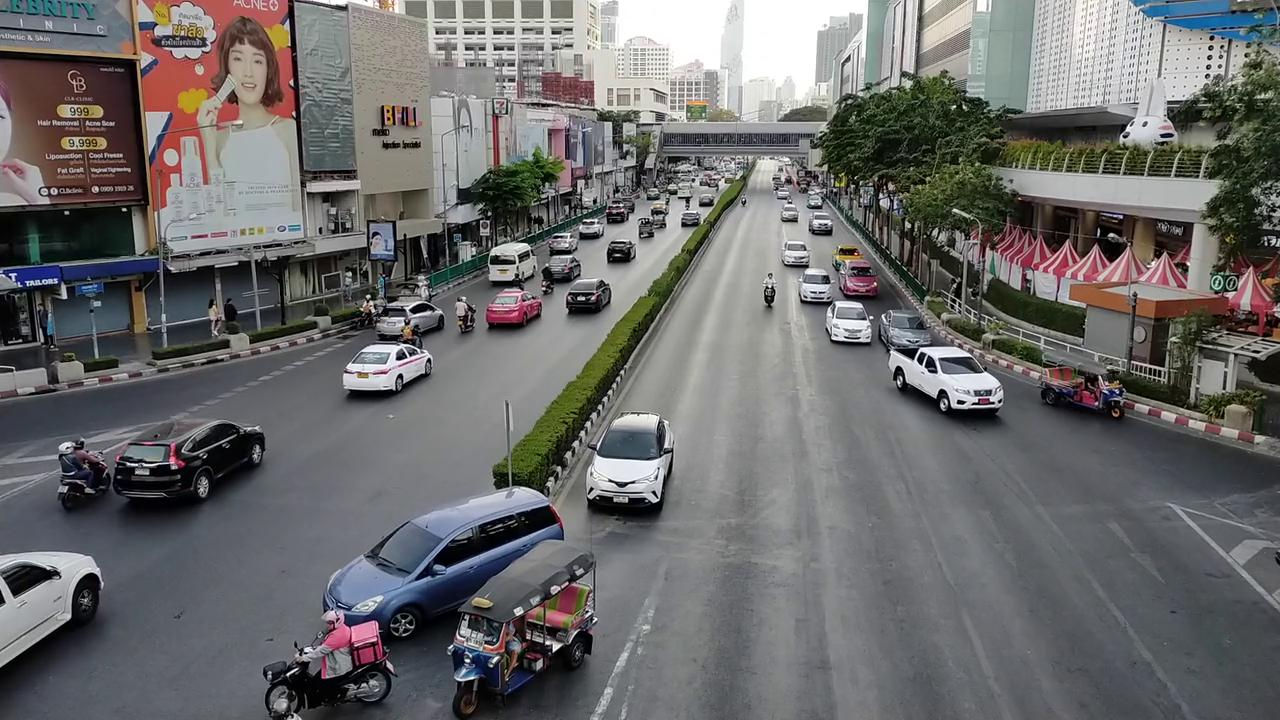
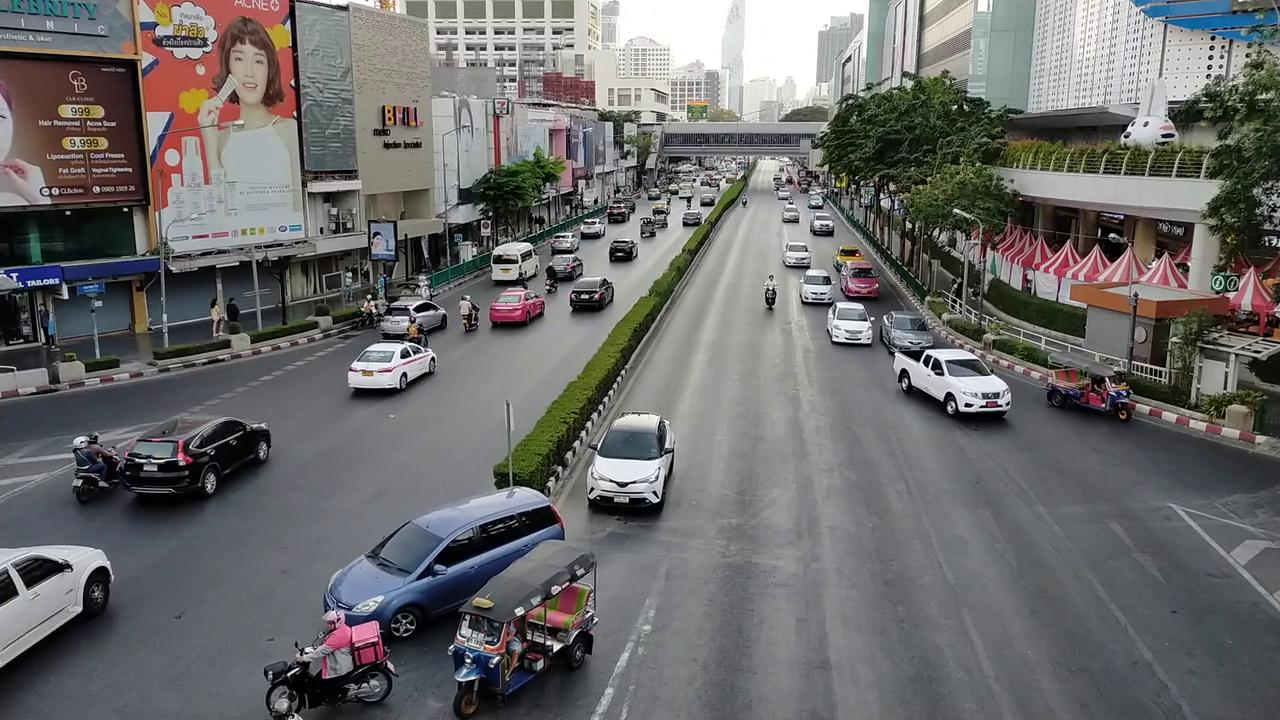
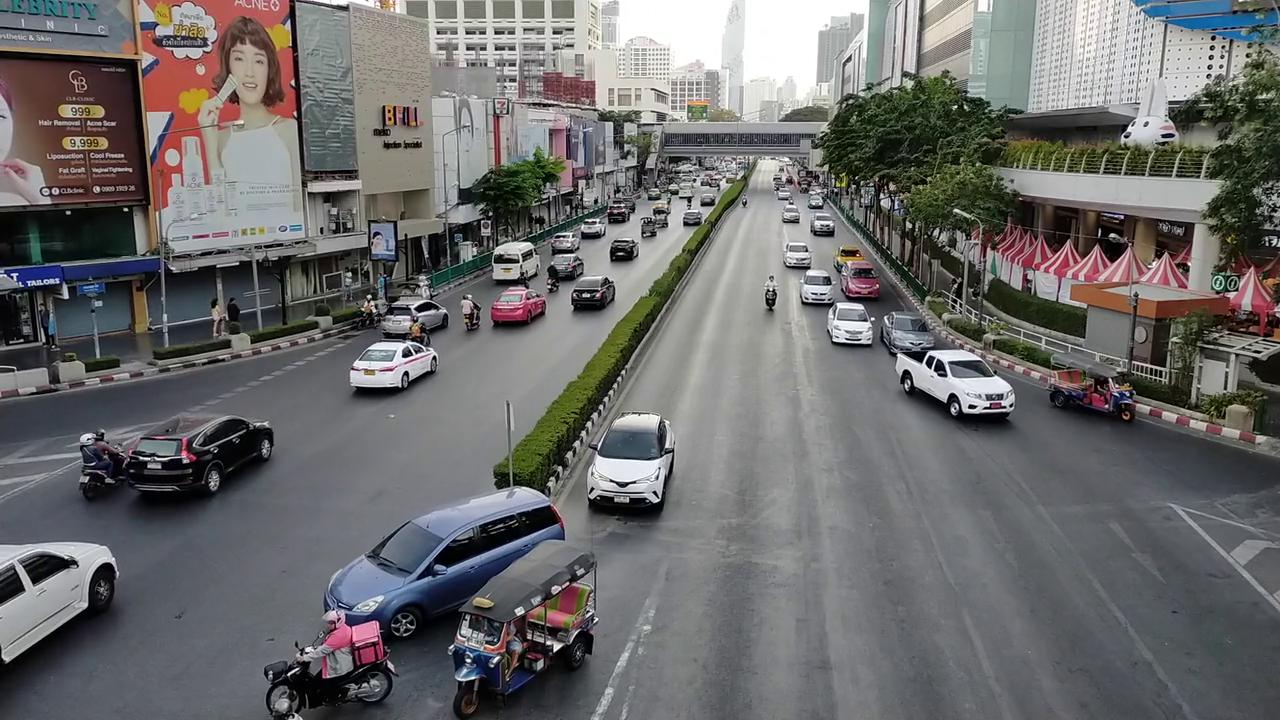

----------------------------------------
Exception occurred during processing of request from ('127.0.0.1', 51710)
Traceback (most recent call last):
  File "/Users/asiegel/miniconda3/lib/python3.11/socketserver.py", line 317, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/Users/asiegel/miniconda3/lib/python3.11/socketserver.py", line 348, in process_request
    self.finish_request(request, client_address)
  File "/Users/asiegel/miniconda3/lib/python3.11/socketserver.py", line 361, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/Users/asiegel/Dropbox/workspace/pixeltable/pixeltable/pixeltable/env.py", line 315, in __init__
    super().__init__(*args, directory='/', **kwargs)
  File "/Users/asiegel/miniconda3/lib/python3.11/http/server.py", line 671, in __init__
    super().__init__(*args, **kwargs)
  File "/Users/asiegel/miniconda3/lib/python3.11/socketserver.py", line 755, in __init__
    self.handle()
  Fil

In [14]:
frames_view.select(frames_view.pos, frames_view.frame, frames_view.frame.width, frames_view.frame.height).show(5)

One advantage of using Pixeltable's component view mechanism is that Pixeltable does not physically store the frames. Instead, Pixeltable re-extracts the frames on retrieval using the frame index, which can be done very efficiently and avoids any storage overhead (which can be quite substantial for video frames).

## Object detection with Pixeltable

Now let's apply an object detection model to our frames. Pixeltable includes built-in support for a number of models; we're going to use the ResNet family of models provided by the Huggingface Transformers library.

Recall that Pixeltable uses _computed columns_ for data manipulation (we encountered them in the Pixeltable Basics tutorial). Adding object detection as an incremental step in our workflow is as simple as adding a computed column to the `frames` view. This may take some time to execute (the model first has to be downloaded, then run against all 462 frames), so please be patient.

In [15]:
from pixeltable.functions.huggingface import detr_for_object_detection

frames_view['detect_resnet_50'] = detr_for_object_detection(
    frames_view.frame,
    model_id='facebook/detr-resnet-50',
    threshold=0.8
)

Added column `detect_resnet_50` to table `frames`.
Computing cells: 100%|████████████████████████████████████████| 462/462 [13:36<00:00,  1.77s/ cells]
Added 462 column values with 0 errors.


The new column is now part of the schema of `frames_view`:

In [16]:
frames_view

Column Name,Type,Computed With
pos,int,
frame_idx,int,
pos_msec,float,
pos_frame,float,
frame,image,
detect_resnet_50,json,"huggingface.detr_for_object_detection(frame, model_id='facebook/detr-resnet-50', threshold=0.8)"
video,video,


We can see that the object detection algorithm produced quite a lot of data for each frame.

frame,detect_resnet_50
,"{'boxes': [[358.4552307128906, 378.5899658203125, 371.4723815917969, 415.7088928222656], [146.70697021484375, 1098.2471923828125, 222.4833221435547, 1272.6673583984375], [315.9252624511719, 497.0510559082031, 343.1532287597656, 567.8138427734375], [211.94342041015625, 489.6133117675781, 219.21310424804688, 542.434814453125], [430.6621398925781, 490.50408935546875, 439.6257019042969, 543.405517578125], [22.902097702026367, 816.9598388671875, 51.31005859375, 918.1576538085938], [496.713623046875, 607.7659912109375, 564.180419921875, 734.6697998046875], [123.96875762939453, 529.0372314453125, 131.87986755371094, 571.3759765625], [463.3439636230469, 532.524658203125, 493.2656555175781, 610.2831420898438], [439.2722473144531, 421.9234619140625, 457.9563903808594, 469.78973388671875], [429.2818603515625, 476.9346923828125, 437.49224853515625, 536.7118530273438], [334.5252685546875, 372.1284484863281, 347.9964599609375, 409.887451171875], [493.5350036621094, 548.1819458007812, 527.1695556640625, 621.64501953125], [206.47789001464844, 533.4763793945312, 248.02183532714844, 608.0193481445312], [253.12942504882812, 540.87158203125, 265.9716796875, 598.9630737304688], [438.2936096191406, 360.4707336425781, 450.2557373046875, 397.40899658203125], [466.29925537109375, 423.7764892578125, 485.1700744628906, 472.036376953125], [180.24867248535156, 864.482177734375, 319.01727294921875, 1130.1181640625], [116.84208679199219, 531.0887451171875, 124.86255645751953, 600.5709838867188], [269.2337341308594, 513.8951416015625, 303.8212585449219, 589.06396484375], [24.81747055053711, 795.4153442382812, 50.338523864746094, 893.3071899414062], [251.9134521484375, 530.0556030273438, 263.8497314453125, 592.3060302734375], [188.1681671142578, 609.99365234375, 244.25645446777344, 713.5052490234375], [361.691162109375, 378.5487060546875, 374.49822998046875, 415.1024169921875], [339.09234619140625, 422.3750305175781, 357.10125732421875, 470.4737854003906], [269.9154052734375, 433.08447265625, 299.7562255859375, 512.3184204101562], [23.340646743774414, 543.9571533203125, 33.523155212402344, 628.9072265625], [56.38657760620117, 745.8927001953125, 146.6003875732422, 907.3314819335938], [326.7071838378906, 732.3553466796875, 379.72735595703125, 911.83154296875], [448.1913757324219, 474.21441650390625, 472.3961486816406, 539.5618896484375], [0.07206559181213379, 992.22314453125, 53.055538177490234, 1191.850830078125], [306.71087646484375, 408.341796875, 325.0531921386719, 447.7636413574219], [303.65478515625, 459.94488525390625, 324.73480224609375, 509.9127502441406], [470.8584899902344, 461.11627197265625, 495.5753173828125, 533.0569458007812], [381.61383056640625, 368.4244384765625, 394.4517822265625, 404.2573547363281], [250.22752380371094, 976.3367919921875, 338.03143310546875, 1246.3524169921875]], 'labels': [3, 4, 3, 1, 4, 4, 3, 1, 3, 3, 1, 3, 3, 3, 4, 3, 3, 3, 1, 3, 1, 1, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 4], 'scores': [0.8172485828399658, 0.9963443875312805, 0.9843031167984009, 0.9266019463539124, 0.9860986471176147, 0.9889780879020691, 0.9622930884361267, 0.863234281539917, 0.9899665117263794, 0.965829610824585, 0.9706177115440369, 0.8756415247917175, 0.9579641819000244, 0.9782828092575073, 0.9784789681434631, 0.883997917175293, 0.8295280337333679, 0.9964492321014404, 0.978238582611084, 0.9888625741004944, 0.9890163540840149, 0.9892979860305786, 0.9781622290611267, 0.8510439395904541, 0.9816378951072693, 0.974648654460907, 0.8004194498062134, 0.9932637214660645, 0.9984197616577148, 0.9432265758514404, 0.9964852333068848, 0.9065613746643066, 0.8890084028244019, 0.9289819002151489, 0.9641920924186707, 0.9841872453689575], 'label_text': ['car', 'motorcycle', 'car', 'person', 'motorcycle', 'motorcycle', 'car', 'person', 'car', 'car', 'person', 'car', 'car', 'car', 'motorcycle', 'car', 'car', 'car', 'person', 'car', 'person', 'person', 'car', 'car', 'car', 'car', 'person', 'car', 'car', 'car', 'car', 'car', 'car', 'car', 'car', 'm
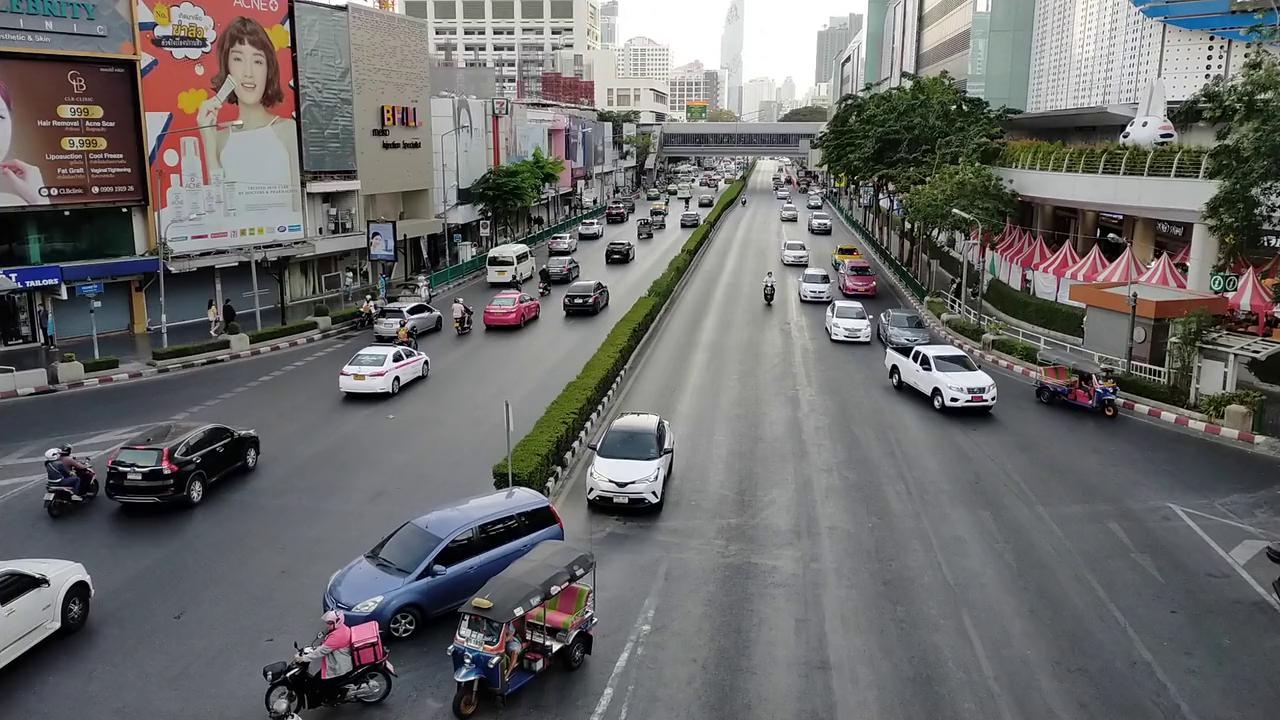

In [17]:
frames_view.select(frames_view.frame, frames_view.detect_resnet_50).show(1)

Now let's create a new set of images, to illustrate the detected bounding boxes superimposed on the original images. There's no built-in Pixeltable function to do this, but we can easily create our own. We'll use the `@pxt.udf` decorator for this, as we first saw in the Pixeltable Basics tutorial.

In [18]:
import PIL.Image
import PIL.ImageDraw

@pxt.udf
def draw_boxes(img: PIL.Image.Image, boxes: list[list[float]]) -> PIL.Image.Image:
    result = img.copy()
    d = PIL.ImageDraw.Draw(result)
    for box in boxes:
        d.rectangle(box, width=3)
    return result

This function takes two arguments, `img` and `boxes`, and returns the new, annotated image. We could create a new computed column with the annotated images, but we don't have to; sometimes it's easier just to use Pixeltable's powerful `select` comprehension:

frame,col_1
,

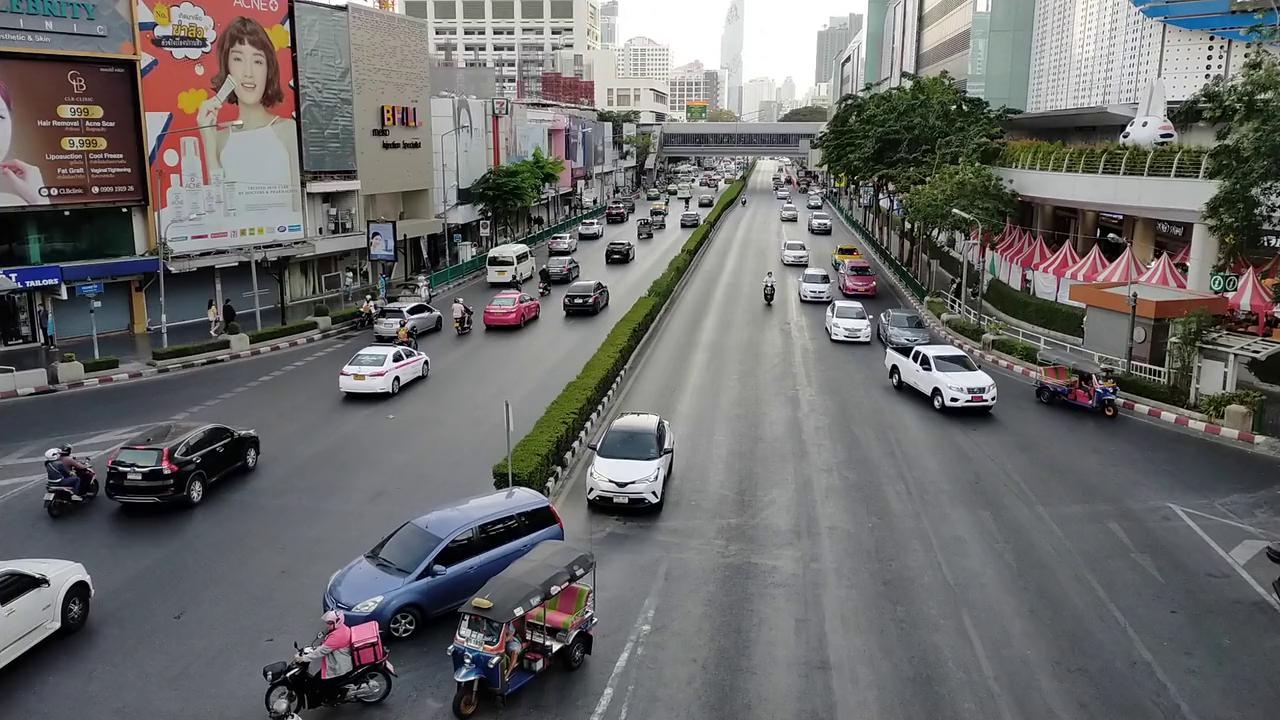
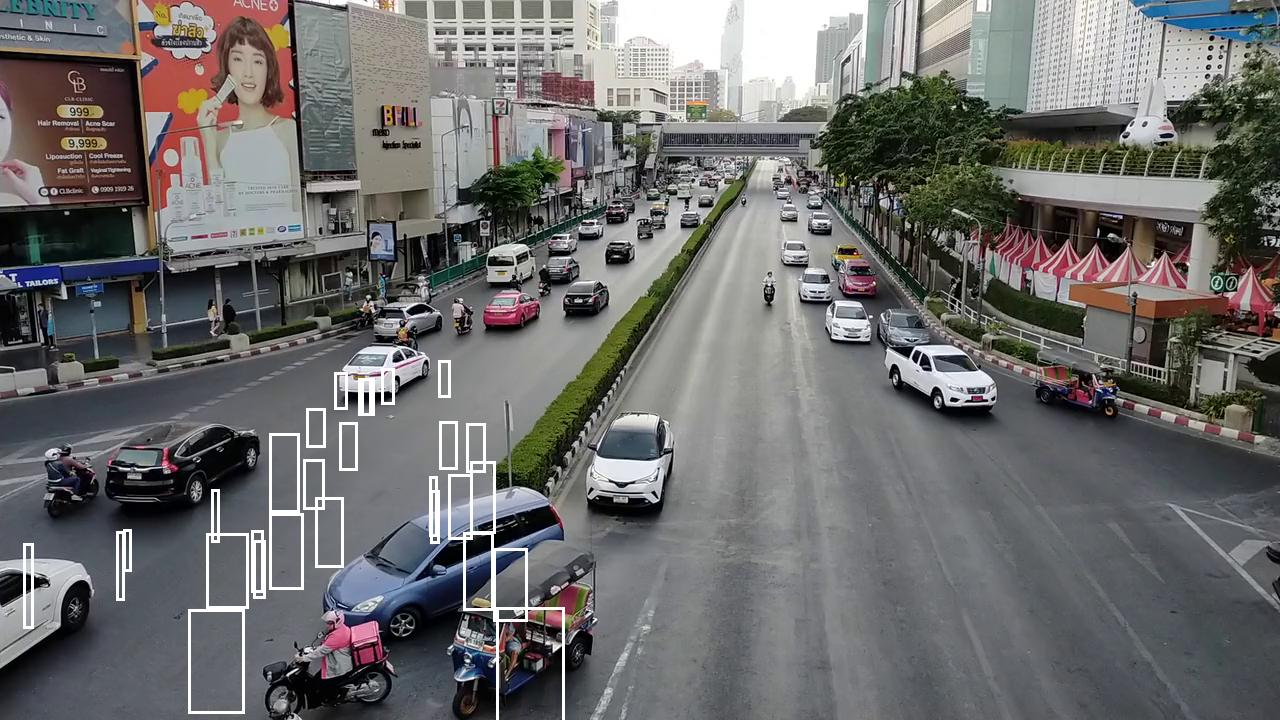

In [19]:
frames_view.select(frames_view.frame, draw_boxes(frames_view.frame, frames_view.detect_resnet_50.boxes)).show(1)

We can then use `detect()` in the Pixeltable index operator using standard Python function call syntax:

frame  \
0  <PIL.Image.Image image mode=RGB size=1280x720 ...   

                                               col_1  
0  {'boxes': [[338.0175476074219, 332.30703735351...
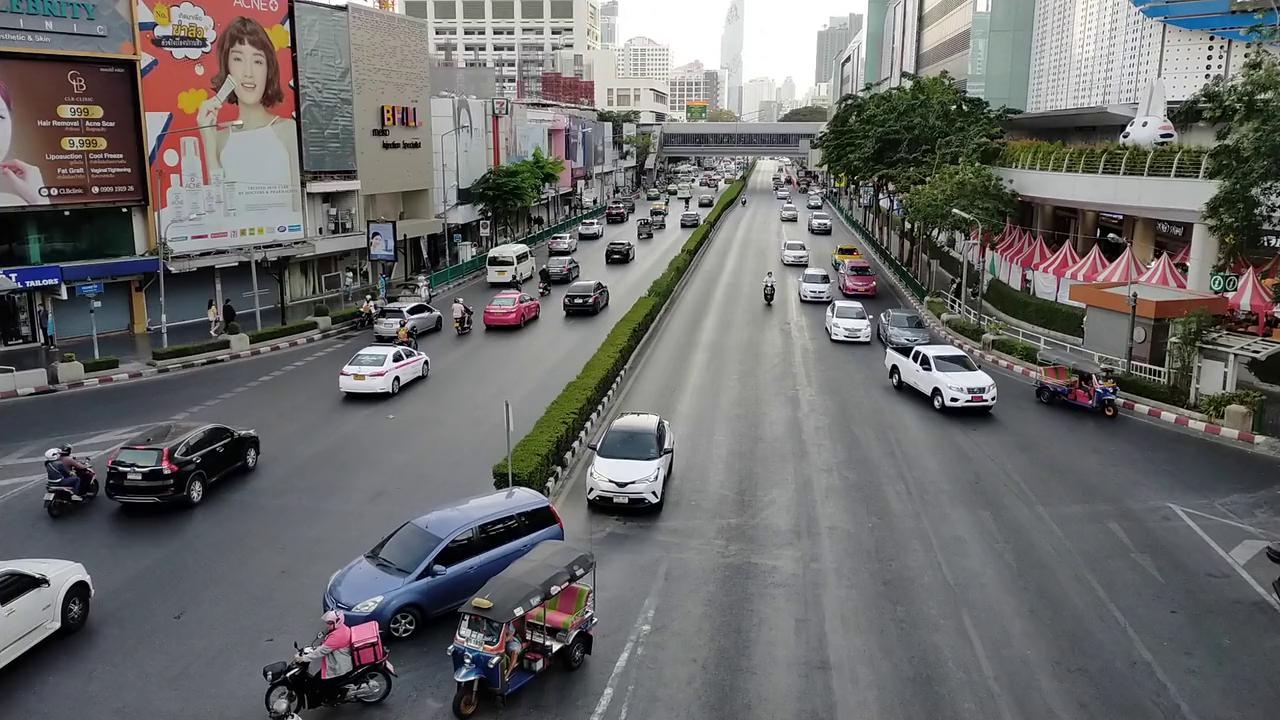

In [11]:
f.where(f.pos == 0).select(f.frame, detect(f.frame)).show(1)

This works as expected, and we now add the detections as a computed column `detections` to the table.

Running model inference is generally an expensive operation; adding it as a computed column makes sure it only runs once, at the time the row is inserted. After that, the result is available as part of the stored table data.

Note that for computed columns of any type other than `image`, the computed values are **always** stored (ie, `stored=True`).

In [12]:
f.add_column(detections=detect(f.frame))

Computing cells:   0%|          | 0/462 [00:00<?, ?cells/s]

added 462 column values with 0 errors


UpdateStatus(num_rows=462, num_computed_values=462, num_excs=0, updated_cols=[], cols_with_excs=[])

We can create a simple function `draw_boxes()` to visualize detections:

In [13]:
import PIL.ImageDraw

@pxt.udf(return_type=pxt.ImageType(), param_types=[pxt.ImageType(), pxt.JsonType()])
def draw_boxes(img, boxes):
    result = img.copy()
    d = PIL.ImageDraw.Draw(result)
    for box in boxes:
        d.rectangle(box, width=3)
    return result

This function takes two arguments:
- `img` has type `image` and receives an instance of `PIL.Image.Image`
- `boxes` has type `json` and receives a JSON-serializable structure, in this case a list of 4-element lists of floats

When we "call" this function, we need to pass in the frame and the bounding boxes identified in that frame. The latter can be selected with the JSON path expression `t.detections.boxes`:

frame,col_1
,

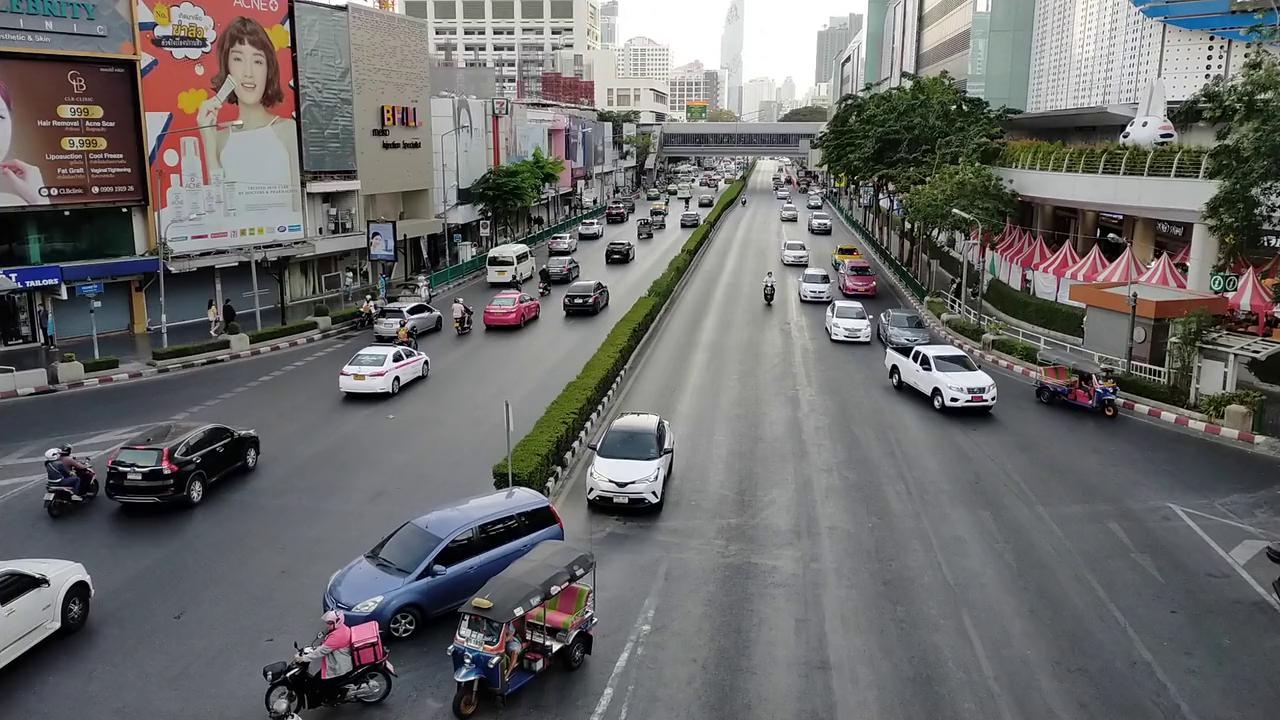
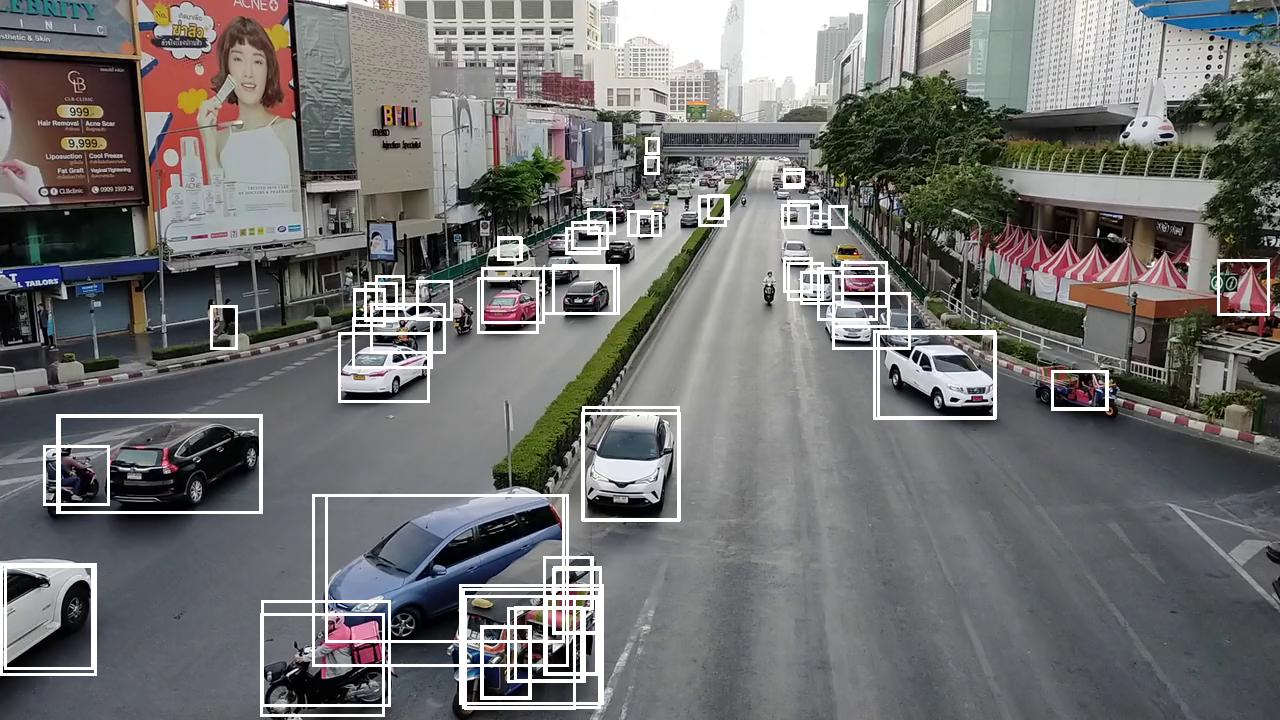

In [14]:
f.where(f.frame_idx == 0).select(f.frame, draw_boxes(f.frame, f.detections.boxes)).show(1)

Looking at individual frames gives us some idea of how well our detection algorithm works, but it would be more instructive to turn the visualization output back into a video.

We do that with the built-in function `make_video()`, which is an aggregation function that takes a frame index (actually: any expression that can be used to order the frames; a timestamp would also work) and an image, and then assembles the sequence of images into a video:

In [15]:
f.select(pxt.make_video(f.pos, draw_boxes(f.frame, f.detections.boxes))).group_by(v).show(1)

col_0
""
